In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from colossus.lss.mass_function import massFunction
from astropy.cosmology import WMAP9 as cosmo
import emcee

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

### Setup functions for emcee

In [3]:
def lnprior(k):
    M = k[0]
    z = k[1]
    if Mmin <= M <= Mmax and zmin <= z <= zmax:
        return 0.0
    return -np.inf

def dNdlnMdz(logM, z):
    dVdz = cosmo.differential_comoving_volume(z).value
    M = 10**logM
    dNdlnMdV = massFunction(M, z, mdef='500c', model='tinker08', q_out='dndlnM')*h**3
    dNdlnMdz = dNdlnMdV * dVdz
    return np.log(dNdlnMdz)

def lnprob(k):
    lp = lnprior(k)
    if not np.isfinite(lp):
        return -np.inf
    return lp + dNdlnMdz(k[0], k[1])

### My Metropolis-Hastings sampler

In [4]:
def my_mcmc(steps, burn_in, start_point):
    n = steps+burn_in
    
    x_cur = start_point
    x_next = np.random.uniform(low=[Mmin, zmin], high=[Mmax, zmax], size=(n,2))
    u = np.random.uniform(size=n)
    
    post_cur = dNdlnMdz(x_cur[0], x_cur[1])
    
    posterior = np.zeros((n, 2), dtype=np.ndarray)

    for ii in range(n):
        x_prop = x_next[ii]
        post_prop = dNdlnMdz(x_prop[0], x_prop[1])
        acceptance = min(post_prop/post_cur,1)
        if u[ii] <= acceptance:
            x_cur = x_prop
            post_cur = post_prop
        
        posterior[ii] = x_cur
    
    return posterior[burn_in:]

### Setup cosmology for massFunction & likelihood function

In [5]:
# set cosmology for mass function
cosmology.setCosmology('WMAP9')
# setup h for likelihood function and mass scaling
h = cosmo.H0.value/100

### Setup mass and redshift ranges for sample

In [6]:
Mmin = 13.5 - np.log10(h)
Mmax = 15.8 - np.log10(h)
zmin = 0.05
zmax = 1.0

### Generate array of starting points for emcee and run burn-in steps

In [7]:
# set 2 dimensions (M&z) and no. of walkers
ndim, nwalkers = 2, 10
# 2d array of starting points from full range of M&z
p0 = np.random.uniform(low=[Mmin, zmin], high=[Mmax, zmax], size=(nwalkers,2))
#run 100 steps to burn-in
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0, 100)

### Run emcee sampler

In [8]:
# reset sampler to remove burn-in steps
sampler.reset()
# rerun sampler using burned in points as starting positions
pos, prob, state = sampler.run_mcmc(pos, 100_000)

In [9]:
# flatchain sampler for emcee cluster sample
clus_emcee = sampler.flatchain

### Run my MH sampler

In [13]:
clus_mymcmc = my_mcmc(100_000, 1000, [14.7, 0.5])

### emcee sample Mz plane
* emcee still struggles to probe low probability areas of parameter space: higher mass clusters in general and particularly low $z$, high mass clusters

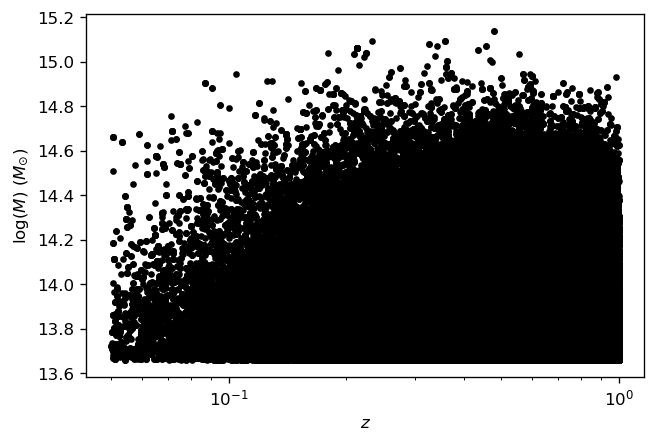

In [14]:
plt.scatter(clus_emcee.T[1], clus_emcee.T[0], marker='.', color='k')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### MH sample Mz plane

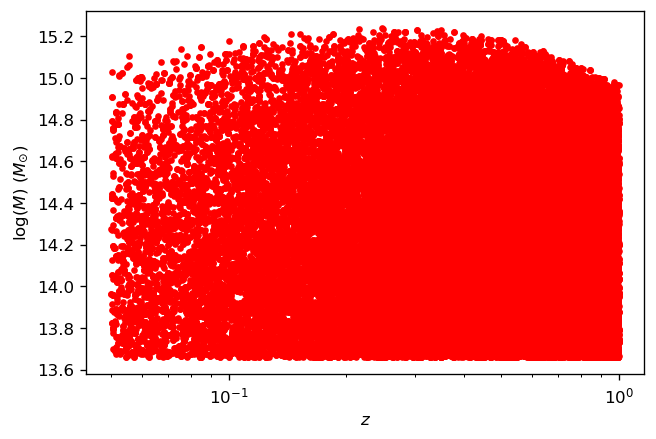

In [15]:
plt.scatter(clus_mymcmc.T[1], clus_mymcmc.T[0], marker='.', color='red')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### Load clusters sampled from interpolated hmf mass functions and plot Mz plane
* clusters sampled with my_mcmc function but performing 2d interpolation between 5 hmf mass functions' resulting $\frac{dn}{d\,{\rm log}_{10}M}$
* code which generated this can be found [here](https://github.com/ryanduffy92/generate_cluster_sample/blob/main/sample_mass_function.py)
* primary differences: higher mass clusters sampled (can be seen below)

In [17]:
clus_interp = pd.read_csv('full_py.dat')

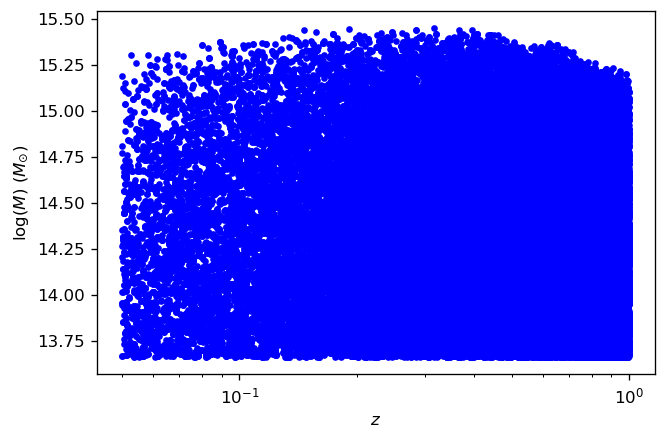

In [20]:
plt.scatter(clus_interp.z, clus_interp.logm, marker='.', color='blue')
plt.xlabel(r'$z$')
plt.ylabel(r'log($M$) ($M_{\odot}$)')
plt.xscale('log')

### Load fake NORAS sample
* 301 clusters randomly sampled from interpolated mass functions with *ROSAT* $F_{X}>3.0\times10^{-12}$ erg/s/cm2

In [21]:
noras = pd.read_csv('noras.csv')

### Calculate scaling relations

In [22]:
def calc_y(x, A, B, xnorm, ynorm):
	return ynorm * A * (x/xnorm)**B

rr = np.arange(1.5, 21.5, 0.5)
# scaling relation from LIRA
ys = calc_y(rr, 10**-0.05612, 2.84643, 5.0, 5.0e44)
# input relation from PICACS
ys_input = calc_y(rr, 0.82, 2.87, 5.0, 5.0e44)

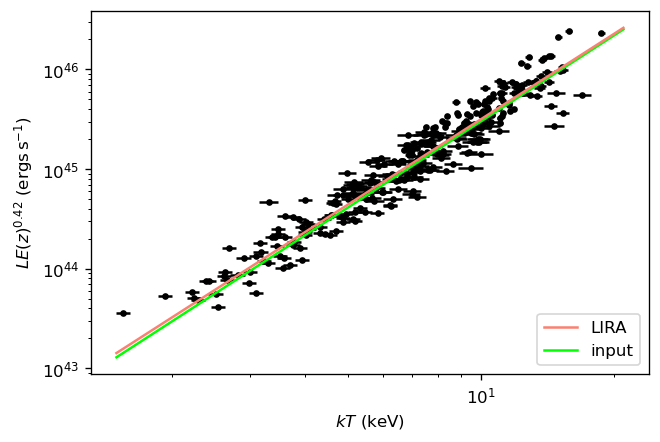

In [25]:
plt.errorbar(noras.kt_obs, noras.l_obs*noras['Ez']**0.42, xerr=noras.kt_obs_err*noras.kt_obs, yerr=noras.l_obs_err*noras.l_obs*noras['Ez']**0.42, linestyle='', marker='.', color='k', zorder=0)
plt.plot(rr, ys, color='salmon', zorder=10, label='LIRA')
plt.plot(rr, ys_input, color='lime', zorder=5, label='input')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$kT$ (keV)')
plt.ylabel(r'$LE(z)^{0.42}$ (ergs$\,$s$^{-1}$)')
plt.legend(loc='lower right')